<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/resnet34_oracle5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet34 Oracle with X examples
Note that because the 'car' dataset only has 2460 examples, there are not as many images as the num_examples_name.

This block can be run with no changes.

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
import os
# print(fastai.__version__ )

In [ ]:
# Definitions
dataset ='/content/drive/My Drive/Haptic Vest/dataset_person_car'
classes = ['neither', 'person', None , 'car']
all_processed_imgs_dir = '/content/drive/My Drive/Haptic Vest/person_car_other_imgs_processed'

In [ ]:
train_ids = np.loadtxt(dataset, dtype=(int, int))
train_ids_dict = dict(train_ids)

In [ ]:
x_train_ids, y_train_ids = train_ids[:,0], train_ids[:,1]
assert(x_train_ids.shape == y_train_ids.shape)
x_train_ids[0], y_train_ids[0]
print(f"There are {len(x_train_ids)} images, set(x_train_ids) = {len(set(x_train_ids))} images.")

There are 77650 images, set(x_train_ids) = 77033 images.


In [ ]:
# IMPORTANT: If this cell crashes with an Input/Output error, you just need
#            to restart the kernel and try again until it works.
fnames = get_image_files(all_processed_imgs_dir)
labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in fnames]
print(f"There are {len(labels)} labels.")


KeyboardInterrupt: ignored

# Get dataset_X from zip


# You need to change lines here to get the specific dataset.
Download the .zip of your images into Colab's directory, not
into My Drive (your mounted Google Drive).

In [ ]:

# !apt install unzip
# !mkdir dataset_X

######################### 
# CHANGE HERE
######################### 
num_examples_name = '5000'
######################### 

dataset_X_parent = '/content/dataset_' + num_examples_name
dataset_X = '/content/dataset_' + num_examples_name + '/processed_subset' + num_examples_name
# os.mkdir(dataset_X_parent)  # Uncomment if directory doesn't exist
!unzip '/content/processed_subset5000-20201022T193533Z-001.zip' -d dataset_5000

Streaming output truncated to the last 5000 lines.
  inflating: dataset_5000/processed_subset5000/000000230712.jpg  
  inflating: dataset_5000/processed_subset5000/000000296489.jpg  
  inflating: dataset_5000/processed_subset5000/000000427362.jpg  
  inflating: dataset_5000/processed_subset5000/000000198164.jpg  
  inflating: dataset_5000/processed_subset5000/000000460145.jpg  
  inflating: dataset_5000/processed_subset5000/000000198139.jpg  
  inflating: dataset_5000/processed_subset5000/000000394776.jpg  
  inflating: dataset_5000/processed_subset5000/000000329239.jpg  
  inflating: dataset_5000/processed_subset5000/000000329152.jpg  
  inflating: dataset_5000/processed_subset5000/000000230893.jpg  
  inflating: dataset_5000/processed_subset5000/000000329125.jpg  
  inflating: dataset_5000/processed_subset5000/000000132503.jpg  
  inflating: dataset_5000/processed_subset5000/000000558528.jpg  
  inflating: dataset_5000/processed_subset5000/000000198162.jpg  
  inflating: dataset_5000

In [ ]:
dataset_X_ids = {}
for entry in os.scandir(dataset_X):
  if os.path.basename(entry)[0] == '.':
    continue
  dataset_X_ids[int(os.path.basename(entry)[:-4])] = train_ids_dict[int(os.path.basename(entry)[:-4])]
len(dataset_X_ids)

12380

In [ ]:
dataset_X_fnames = get_image_files(dataset_X)
dataset_X_labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in dataset_X_fnames]
print(len(dataset_X_labels))

12380


# FastAI

## Make databunch_X
Here we have a 90/10 train/dev split

In [ ]:
databunch_X = ImageDataBunch.from_lists(dataset_X, dataset_X_fnames, dataset_X_labels, valid_pct=0.1).normalize(imagenet_stats)
# print(databunch_X)

([0, 1, 3], 3, 11142, 1238)

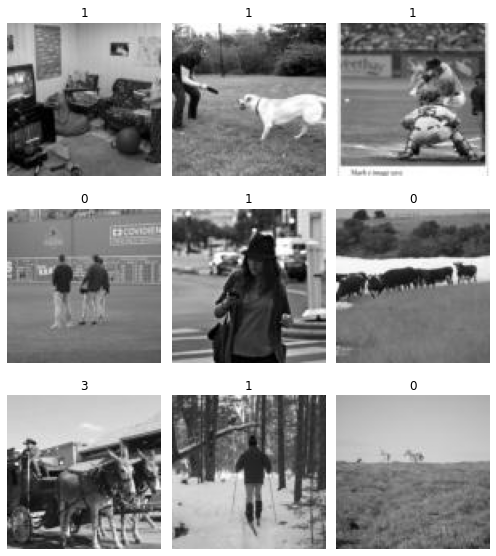

In [ ]:
np.random.seed(42)

databunch_X.show_batch(rows=3, figsize=(7,8))
databunch_X.classes, databunch_X.c, len(databunch_X.train_ds), len(databunch_X.valid_ds)

## Stage 1

In [ ]:
learner_X = cnn_learner(databunch_X, models.resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learner_X.fit_one_cycle(40)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.286174,0.856019,0.344103,0.655897,00:10
1,1.094334,0.814389,0.325525,0.674475,00:10
2,0.947196,0.788601,0.321486,0.678514,00:10
3,0.826475,0.735929,0.300485,0.699515,00:10
4,0.732488,0.724739,0.310985,0.689015,00:10
5,0.723818,0.711037,0.295638,0.704362,00:10
6,0.656762,0.683045,0.279483,0.720517,00:10
7,0.629066,0.692171,0.289176,0.710824,00:10
8,0.620146,0.676411,0.276252,0.723748,00:10
9,0.589476,0.671469,0.255250,0.744750,00:10


In [ ]:
learner_X.save('learner' + num_examples_name + 'stage-1')


In [ ]:
interp = ClassificationInterpretation.from_learner(learner_X)

losses,idxs = interp.top_losses()

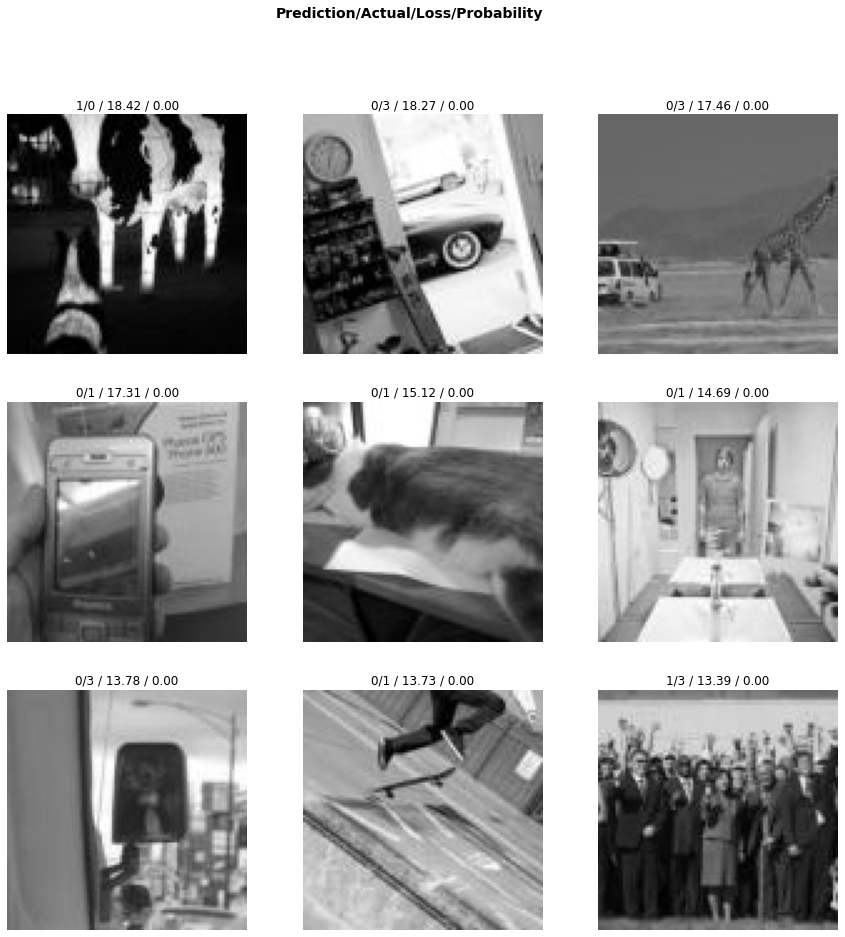

In [ ]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)


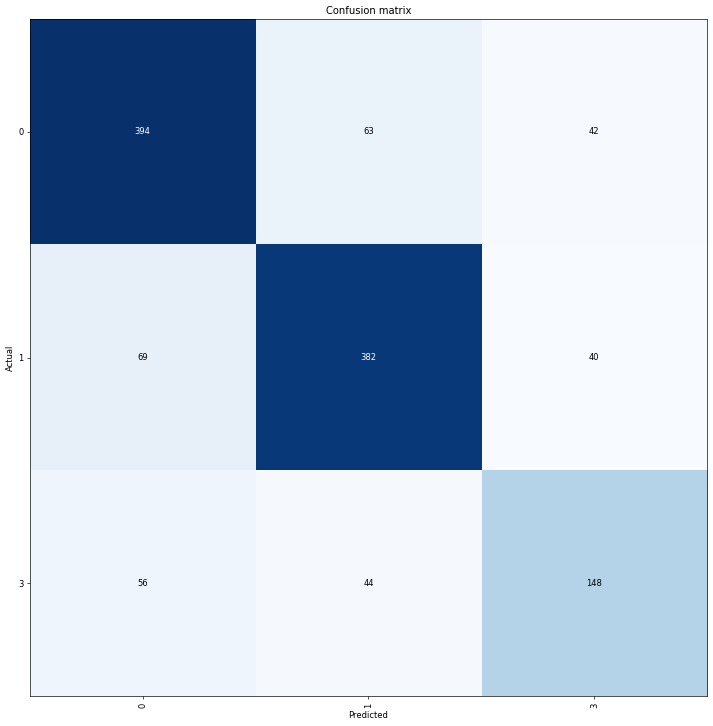

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Stage 2

In [ ]:
learner_X.load('learner' + num_examples_name + 'stage-1');

In [ ]:
learner_X.unfreeze()

In [ ]:
learner_X.lr_find()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


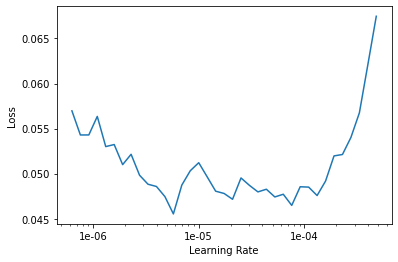

In [ ]:
learner_X.recorder.plot()


In [ ]:
learner_X.fit_one_cycle(20, max_lr=slice(3e-6,3e-4))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.134789,1.087396,0.260097,0.739903,00:15
1,0.121746,1.081361,0.256866,0.743134,00:15
2,0.117523,1.094639,0.247981,0.752019,00:15
3,0.115469,1.117658,0.252827,0.747173,00:15
4,0.104844,1.138407,0.269790,0.730210,00:15
5,0.102796,1.135343,0.264943,0.735057,00:15
6,0.097984,1.192153,0.257674,0.742326,00:15
7,0.073578,1.210934,0.249596,0.750404,00:15
8,0.058414,1.297677,0.257674,0.742326,00:15
9,0.042444,1.256438,0.256058,0.743942,00:15


In [ ]:
learner_X.lr_find()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


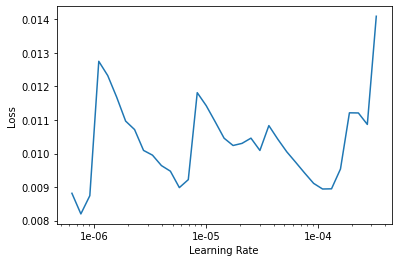

In [ ]:
learner_X.recorder.plot()


In [ ]:
learner_X.save('learner' + num_examples_name + 'stage-2')


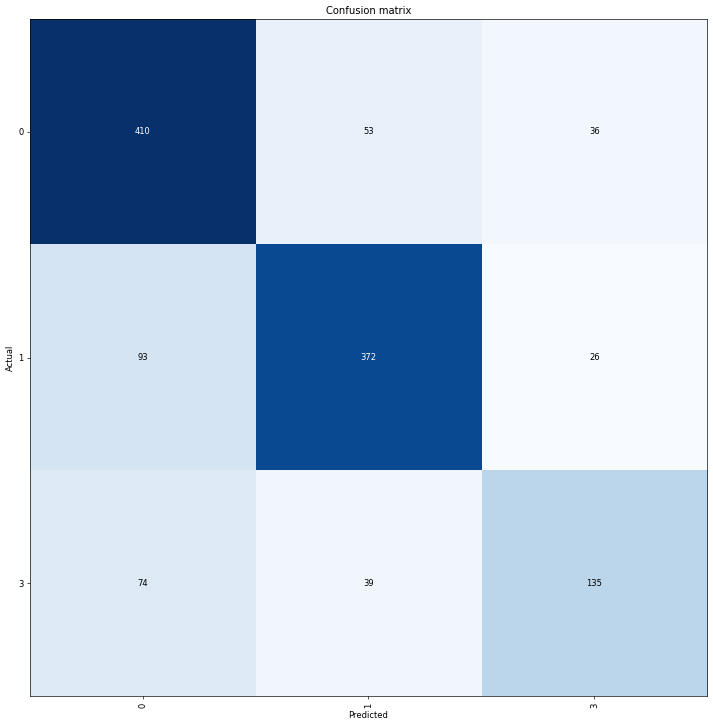

In [ ]:
interp = ClassificationInterpretation.from_learner(learner_X)

losses,idxs = interp.top_losses()
# interp.plot_top_losses(9, figsize=(15,15), heatmap=True)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Cleanup dataset_X
It turns out that MSCOCO is not that great a dataset, so here's a widget that helps you clean the dataset.

In [ ]:
from fastai.widgets import *

In [ ]:
databunch_X_clean = ImageDataBunch.from_lists(dataset_X, dataset_X_fnames, dataset_X_labels)


In [ ]:
learn_clean_X = cnn_learner(databunch_X_clean, models.resnet34, metrics=error_rate)

learn_clean_X.load('learner' + num_examples_name + 'stage-2');

In [ ]:
ds_formatter_X, idxs_formatter_X = DatasetFormatter().from_toplosses(learn_clean_X)

In [ ]:
ImageCleaner(ds_formatter_X, idxs_formatter_X, dataset_X)


Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

([0, 1, 3], 3, 8912, 990)

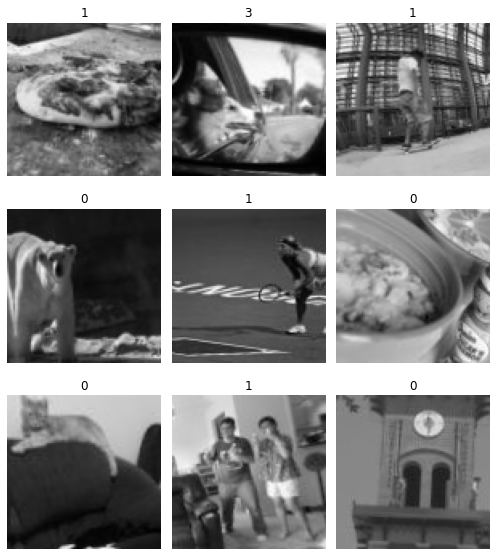

In [ ]:
np.random.seed(42)
dataset_X_clean = ImageDataBunch.from_csv(dataset_X, folder=".", valid_pct=0.1, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=96, num_workers=4).normalize(imagenet_stats)

dataset_X_clean.classes

dataset_X_clean.show_batch(rows=3, figsize=(7,8))
dataset_X_clean.classes, dataset_X_clean.c, len(dataset_X_clean.train_ds), len(dataset_X_clean.valid_ds)

In [ ]:
learn_clean_X = cnn_learner(dataset_X_clean, models.resnet34, metrics=[error_rate, accuracy])

In [ ]:
learn_clean_X.fit_one_cycle(20, max_lr=3e-3)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.344006,0.838741,0.317172,0.682828,00:19
1,1.100868,0.742262,0.279798,0.720202,00:19
2,0.888042,0.685791,0.268687,0.731313,00:19
3,0.732537,0.647699,0.245455,0.754545,00:19
4,0.667994,0.622950,0.245455,0.754545,00:19
5,0.677468,0.594366,0.251515,0.748485,00:19
6,0.635505,0.597963,0.243434,0.756566,00:19
7,0.626675,0.599717,0.242424,0.757576,00:19
8,0.601547,0.579456,0.228283,0.771717,00:19
9,0.587298,0.571505,0.233333,0.766667,00:19
